# **Theoretical questions**

**Q1: Explain the minimax loss function in GANs and how it ensures competitive training**

The minimax loss function in GAN defines a two-player zero-sum game between the generator and the discriminator. This function is

$$\min_G \max_D \Big(\mathbb{E}[\log D(x)]+\mathbb{E}[1-\log D(x)]\Big).$$

The discriminator aims to maximize this value by correctly classifying real data samples as real and generated samples as fake, while the generator aims to minimize it by producing samples that the discriminator can not distinguish from real data.

Good discriminator's work results in that the generator receives stronger gradients that push it to generate more realistic data. Conversely, as the generator improves, the discriminator is forced to learn more discriminative features.

**Q2: What is mode collapse, Why can mode collapse occur during GAN training? and how can it be mitigated?**

Mode collapse is a failure mode in GAN training where the generator produces a limited variety of outputs, mapping many different input noise vectors to the same or a few similar samples instead of capturing the full data distribution.

It occurs because the generator can find a possibility to fool the discriminator by exploiting its weaknesses, leading to low loss without learning the true diversity of the data. This is often caused by an imbalance in training, unstable adversarial dynamics, or a discriminator that provides weak or uninformative gradients.

Mode collapse can be mitigated by techniques that encourage diversity and stabilize training, such as feature matching, minibatch discrimination, adding noise or regularization to the discriminator, using alternative loss functions (e.g., Wasserstein GAN), or carefully balancing the training updates between the generator and discriminator.

**Q3: Explain the role of the discriminator in adversarial training?**

The discriminator acts as a critic in adversarial training, learning to distinguish between real data samples and samples generated by the generator. By providing feedback in the form of gradients that indicate how “real” generated samples appear, the discriminator guides the generator toward producing more realistic and data-consistent outputs. This adversarial interaction ensures that the generator continuously improves by correcting its mistakes based on the discriminator’s evolving decision boundary.

**Q4: How do metrics like IS and FID evaluate GAN performance?**

Metrics such as Inception Score (IS) and Fréchet Inception Distance (FID) evaluate GAN performance by measuring the quality and diversity of generated samples using features extracted from a pretrained Inception network. IS assesses how confidently generated images are classified into distinct classes and how diverse those classes are, favoring images that are both sharp and varied. FID compares the statistical similarity between real and generated image distributions by modeling their feature representations as multivariate Gaussians, with lower FID values indicating closer alignment to the real data distribution. Together, these metrics provide quantitative measures of realism and diversity in GAN outputs.

# **GAN training**

Import packages

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import time

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Import training dataset

In [2]:
# change MNIST on CIFAR 10: load and preprocess data
# (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()                # MNIST
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()                # CIFAR 10

train_images.shape

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


(50000, 32, 32, 3)

In [3]:
train_images = train_images.reshape( -1, *train_images.shape[1:] ).astype('float32')
train_images = (train_images - 127.5) / 127.5                                    # Normalize to [-1, 1]

BUFFER_SIZE = train_images.shape[0]
BATCH_SIZE = 256
# LATENT_DIM = 100

train_dataset = tf.data.Dataset.from_tensor_slices(train_images) \
                  .shuffle(BUFFER_SIZE) \
                  .batch(BATCH_SIZE)

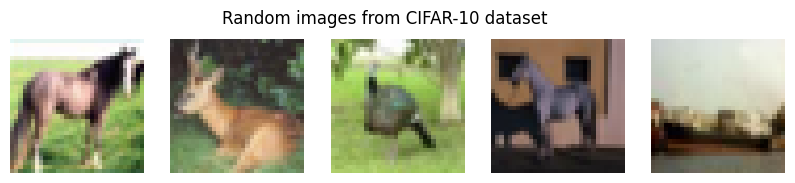

In [4]:
indices = tf.random.shuffle(tf.range(train_images.shape[0]))[:5]
samples = train_images[indices]
samples = (samples + 1) / 2.0  # back to [0,1] for display

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(samples[i])
    plt.axis('off')

plt.suptitle("Random images from CIFAR-10 dataset")
plt.show()

Define architecture

In [5]:
# Generator model
def make_generator_model():
  model = tf.keras.Sequential([
      layers.Dense(8*8*512, use_bias=False, input_shape=(100,)),
      layers.BatchNormalization(),
      layers.LeakyReLU(),
      layers.Reshape((8, 8, 512)),

      layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False),  # 16x16x256
      layers.BatchNormalization(),
      layers.LeakyReLU(),

      layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),  # 32x32x128
      layers.BatchNormalization(),
      layers.LeakyReLU(),

      layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False),  # 32x32x64
      layers.BatchNormalization(),
      layers.LeakyReLU(),

      layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')  # 32x32x3
  ])
  return model

In [6]:
# Discriminator model
def make_discriminator_model():
  model = tf.keras.Sequential([
      layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[ *train_images.shape[1:] ]),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      layers.Flatten(),
      layers.Dense(1)
  ])
  return model

Define loss function and optimizers

In [7]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [8]:
# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# losses history variables
gen_losses = []
disc_losses = []

Function for saving images from different epoches

In [10]:
def generate_and_save_images(model, epoch, latent_dim):
    noise = tf.random.normal([1, latent_dim])
    prediction = model(noise, training=False)[0]
    prediction = (prediction + 1) / 2.0

    os.makedirs("generated_images", exist_ok=True)

    plt.figure(figsize=(3, 3))
    plt.imshow(prediction)
    plt.axis('off')
    plt.title(f"Epoch {epoch}")
    plt.savefig(f"generated_images/image_epoch_{epoch:04d}.png")
    plt.close()

Training loop

In [11]:
# Training function
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, 100])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [12]:
# Training loop
# def train(dataset, epochs):
#   for epoch in range(epochs):
#     for image_batch in dataset:
#       train_step(image_batch)

In [13]:
# New training loop
def train(dataset, epochs):
    seed = tf.random.normal([16, 100])

    for epoch in range(epochs):
        start = time.time()
        g_loss_epoch = []
        d_loss_epoch = []

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            g_loss_epoch.append(g_loss)
            d_loss_epoch.append(d_loss)

        gen_losses.append(tf.reduce_mean(g_loss_epoch))
        disc_losses.append(tf.reduce_mean(d_loss_epoch))

        # save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, 100)

            print(f"Epoch {epoch+1}, "
                  f"G Loss: {gen_losses[-1]:.4f}, "
                  f"D Loss: {disc_losses[-1]:.4f}, "
                  f"Time: {time.time()-start:.2f}s")


In [14]:
# Run the training
train(train_dataset, epochs=250)

Epoch 10, G Loss: 1.4150, D Loss: 0.9442, Time: 69.45s
Epoch 20, G Loss: 2.5464, D Loss: 0.9964, Time: 69.47s
Epoch 30, G Loss: 1.7455, D Loss: 0.8284, Time: 69.65s
Epoch 40, G Loss: 1.9468, D Loss: 0.7788, Time: 69.41s
Epoch 50, G Loss: 2.0114, D Loss: 0.7392, Time: 69.46s
Epoch 60, G Loss: 1.8291, D Loss: 0.9016, Time: 69.45s
Epoch 70, G Loss: 1.8610, D Loss: 0.9591, Time: 69.47s
Epoch 80, G Loss: 1.6948, D Loss: 1.0050, Time: 69.47s
Epoch 90, G Loss: 1.6770, D Loss: 0.9400, Time: 69.52s
Epoch 100, G Loss: 1.6077, D Loss: 0.9330, Time: 69.32s
Epoch 110, G Loss: 1.9915, D Loss: 0.7396, Time: 69.39s
Epoch 120, G Loss: 1.9574, D Loss: 0.8396, Time: 69.53s
Epoch 130, G Loss: 1.8123, D Loss: 0.8176, Time: 69.59s
Epoch 140, G Loss: 2.1668, D Loss: 0.7665, Time: 69.48s
Epoch 150, G Loss: 1.6533, D Loss: 0.9055, Time: 69.53s
Epoch 160, G Loss: 1.5353, D Loss: 0.9270, Time: 69.46s
Epoch 170, G Loss: 2.4518, D Loss: 0.5941, Time: 69.53s
Epoch 180, G Loss: 1.6435, D Loss: 0.8918, Time: 69.47s
E

Results visualization

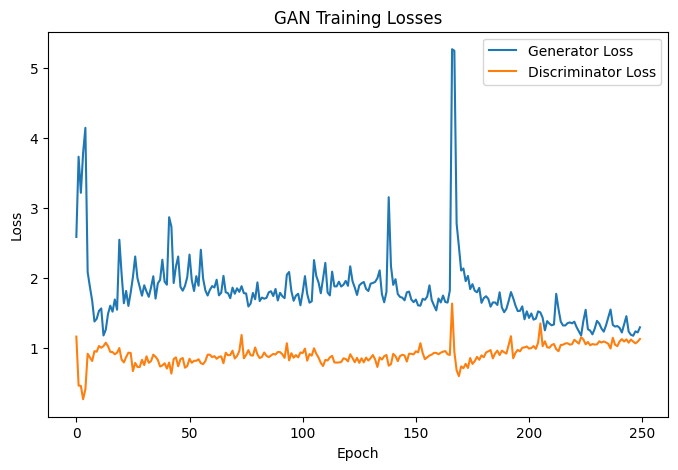

In [15]:
# Loss visualization
plt.figure(figsize=(8, 5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Training Losses')
plt.show()

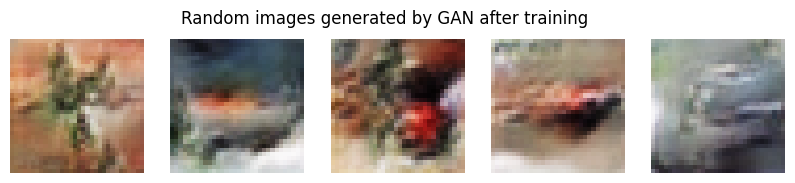

In [16]:
noise = tf.random.normal([5, 100])
generated_images = generator(noise, training=False)
generated_images = (generated_images + 1) / 2.0  # back to [0,1]

plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')

plt.suptitle("Random images generated by GAN after training")
plt.show()

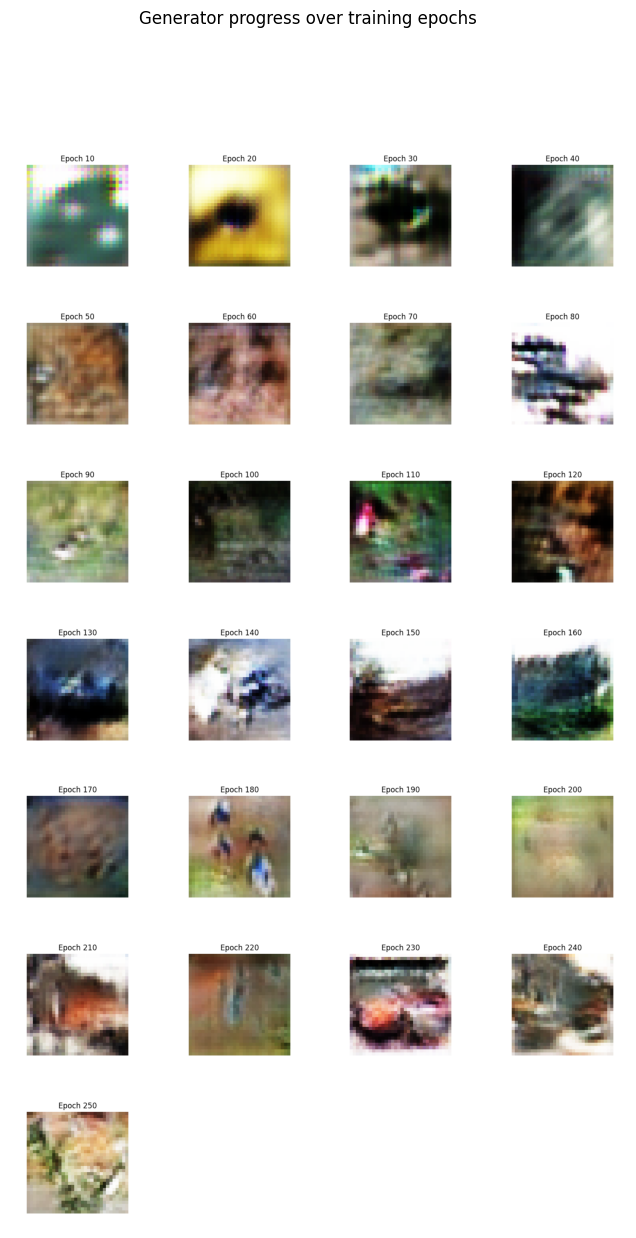

In [19]:
from PIL import Image

image_dir = "generated_images"
image_files = sorted(os.listdir(image_dir))

num_images = len(image_files)

plt.figure(figsize=(4 * 2, (num_images//4+1) * 2))

for i, img_name in enumerate(image_files):
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)

    plt.subplot(num_images//4+1, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    # plt.title(img_name.replace(".png", ""))

plt.suptitle("Generator progress over training epochs")
plt.show()